In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #Tên thư mục chứa ảnh
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE), #kích thước ảnh: 256x256
    batch_size = BATCH_SIZE #kích thương lô ảnh: 32 ảnh
)

Found 6224 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names #Tên lớp
class_names

['Bệnh mốc sương', 'Bệnh sương mai', 'Khỏe mạnh']

In [8]:
len(dataset)

195

In [10]:
for image_batch, label_batch in dataset.take(1): #Kiểm tra một batch
    print (image_batch[0].numpy) #ảnh đầu tiên trong batch ở dạng mảng numpy
    print (label_batch.numpy()) #nhãn của batch ở dạng mảng numpy (0,1,2) tương đương 3 lớp

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[180., 178., 189.],
        [176., 174., 185.],
        [171., 169., 180.],
        ...,
        [141., 138., 147.],
        [135., 132., 141.],
        [136., 133., 142.]],

       [[171., 169., 180.],
        [168., 166., 177.],
        [167., 165., 176.],
        ...,
        [135., 132., 141.],
        [135., 132., 141.],
        [139., 136., 145.]],

       [[175., 173., 184.],
        [173., 171., 182.],
        [174., 172., 183.],
        ...,
        [137., 134., 143.],
        [135., 132., 141.],
        [136., 133., 142.]],

       ...,

       [[205., 202., 209.],
        [204., 201., 208.],
        [203., 200., 207.],
        ...,
        [172., 168., 169.],
        [176., 172., 173.],
        [169., 165., 166.]],

       [[204., 201., 208.],
        [203., 200., 207.],
        [203., 200., 207.],
        ...,
        [173., 169., 170.],
        [178., 174., 175.],
       

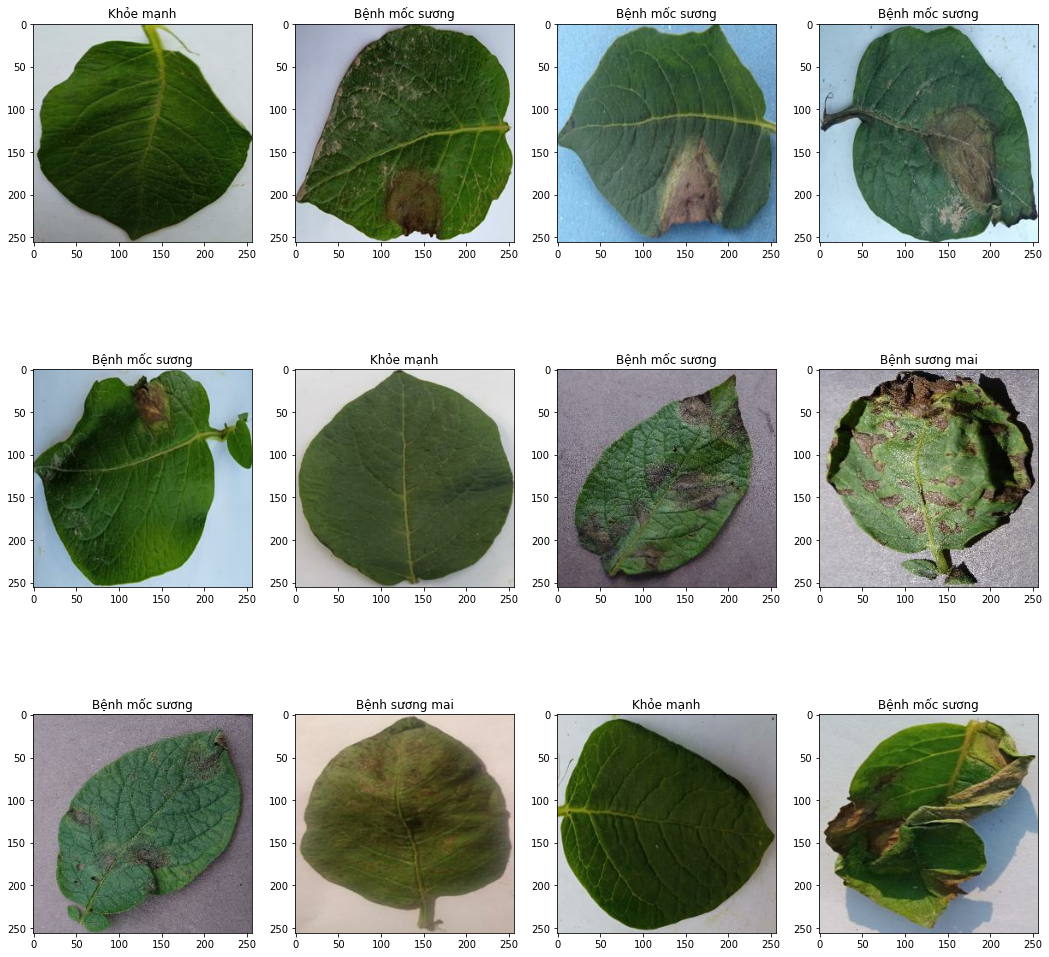

In [11]:
plt.figure(figsize = (18,18)) 
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #xuất ảnh
        plt.title(class_names[label_batch[i]])
        plt.axis("on")

In [12]:
#80% ==> tranning
#20% ==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

156.0

In [14]:
train_ds = dataset.take(156)
len(train_ds)

156

In [15]:
test_ds = dataset.skip(156)
len(test_ds)

39

In [16]:
val_size = 0.1
len(dataset)*val_size

19.5

In [17]:
val_ds = test_ds.take(19)
len(val_ds)

19

In [18]:
test_ds = test_ds.skip(19)
len(test_ds)

20

In [19]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds) #Độ dài dataset
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 5) #thực hiện trộn đữ liệu trước khi tách
    
    train_size = int(train_split * ds_size) #kích thước batch huấn luyện: 156
    val_size = int(val_split * ds_size) #kích thước batch xác thực: 19
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds #trả về dataset 3 tệp đã tách

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

156

In [22]:
len(val_ds)

19

In [23]:
len(test_ds)

20

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
#Pre-processed
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
#Gererate new samples
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
])

In [27]:
#CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
#Set up layer
model = models.Sequential([
   
    resize_and_rescale,
    
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape ),# 32 layer:Trial and Error to detect edges
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),#n_classes:3 neuron,softmax : normalize the probability of your classes
])
model.build(input_shape = input_shape)

In [28]:
model.summary()
#Trainable params: 183,747

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [29]:
#compile using optimizer "adam"
model.compile(
    optimizer = 'adam', #trình tối ưu hóa
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), # loss function
    metrics = ['accuracy'] #kiểu metric: độ chính xác
)

In [ ]:
#Tranning network
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/50
156/156 [==============================] - 287s 2s/step - loss: 0.9184 - accuracy: 0.5267 - val_loss: 0.6876 - val_accuracy: 0.6612
Epoch 2/50
156/156 [==============================] - 126s 808ms/step - loss: 0.4988 - accuracy: 0.7954 - val_loss: 0.7647 - val_accuracy: 0.7188
Epoch 3/50
156/156 [==============================] - 31s 199ms/step - loss: 0.2509 - accuracy: 0.9084 - val_loss: 0.1696 - val_accuracy: 0.9507
Epoch 4/50
156/156 [==============================] - 25s 158ms/step - loss: 0.1502 - accuracy: 0.9490 - val_loss: 0.0922 - val_accuracy: 0.9770
Epoch 5/50
156/156 [==============================] - 26s 168ms/step - loss: 0.1098 - accuracy: 0.9616 - val_loss: 0.1724 - val_accuracy: 0.9359
Epoch 6/50
156/156 [==============================] - 26s 166ms/step - loss: 0.1085 - accuracy: 0.9614 - val_loss: 0.0946 - val_accuracy: 0.9737
Epoch 7/50
156/156 [==============================] - 26s 169ms/step - loss: 0.0891 - accuracy: 0.9678 - val_loss: 0.0742 - val_acc

In [30]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 54s 218ms/step - loss: 0.0256 - accuracy: 0.9904


In [31]:
scores

[0.02562619559466839, 0.9903846383094788]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 156}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc =  history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss =  history.history['loss']
val_loss =  history.history['val_loss']

Text(0.5, 1.0, 'Độ tổn thất của huấn luyện và xác thực')

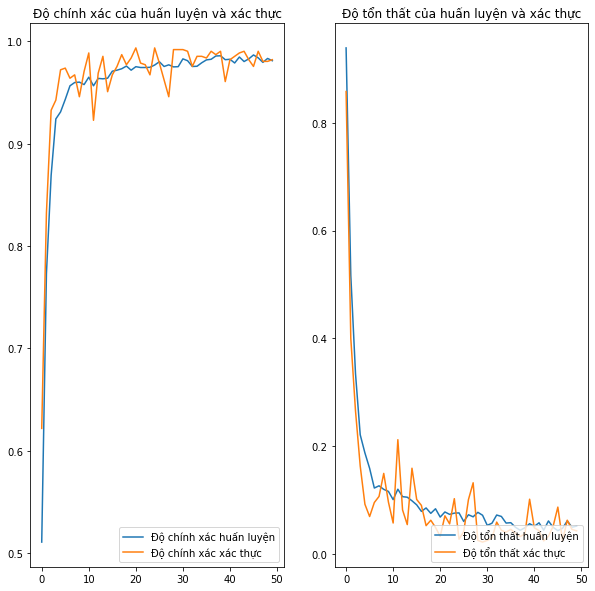

In [38]:
#Plot trainning history on graph
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Độ chính xác huấn luyện')
plt.plot(range(EPOCHS), val_acc, label = 'Độ chính xác xác thực')
plt.legend(loc = 'lower right')
plt.title('Độ chính xác của huấn luyện và xác thực')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Độ tổn thất huấn luyện')
plt.plot(range(EPOCHS), val_loss, label = 'Độ tổn thất xác thực')
plt.legend(loc = 'lower right')
plt.title('Độ tổn thất của huấn luyện và xác thực')

First image to predict
First image label Bệnh mốc sương
Tên dự đoán Bệnh mốc sương


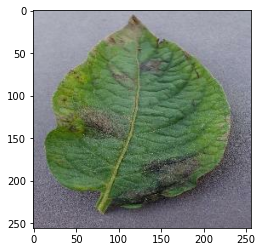

In [44]:
#Make prediction/inference on sample images

import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = (images_batch[0].numpy().astype('uint8'))#RGB
    first_label = labels_batch[0]
    
    print('First image to predict')
    plt.imshow(first_image)
    print("First image label",class_names[first_label])
    
    batch_prediction = model.predict(images_batch) #predict for first 32 image
    print('Tên dự đoán',class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)# Creae a batch
    
    predictions = model.predict(img_array)
     
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [1]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Nhãn gốc:{actual_class},\n Nhãn dự đoán: {predicted_class}.\n Độ chính xác: {confidence}%.")
        
        plt.axis('off')

NameError: name 'plt' is not defined

In [39]:
import os
model_version =  max([int (i) for i in os.listdir("../saved_model")])+1
model.save(f"../saved_model/{model_version}")

INFO:tensorflow:Assets written to: ../saved_model/3\assets
